# Stock Price Prediction using LSTM
1. We will use some historic time-series data of stock prices of some company. 
2. We can install yfinance to get some historical stock data.   
    In conda environment: conda install -c conda-forge yfinance
3. More aboyt yfinance here: https://pypi.org/project/yfinance/
4. For this example, we have already downloaded data for IBM.
5. You can use Download_StockData.ipynb script to download data for your company of choice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import datetime # For time stamps to read data
from sklearn.preprocessing import MinMaxScaler # For scaling data
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [2]:
# Read and data preview
data = pd.read_csv('IBM.csv')
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-11-14,180.850861,181.491394,178.632889,179.110901,113.562332,6316376
1,2011-11-15,179.244736,181.615677,177.476105,180.449326,114.410988,4796224
2,2011-11-16,179.560226,181.548752,178.107071,178.412994,113.119835,4829173
3,2011-11-17,178.594650,180.525818,175.325043,177.562134,112.580391,6109163
4,2011-11-18,178.499039,178.747604,176.539200,177.093689,112.283386,4645181


### Training Data Preparation. Generating Train, Val and Test
1. We will use scaled closing stock price. 
2. We will use a window with stride of 1 to create snippets of time-series data, succeeding single time-stamp value will be  label for each time snippets
3. Each snippet of time-series data will be our one training or test sample.   
i.e. if we choose window_size = 20, we will use t = 1:20 as one sample input and t = 21 as a correspong label and so and so forth. 

In [3]:
data = data[['Date', 'Close']]
data.head()

,Date,Close
0,2011-11-14,179.110901
1,2011-11-15,180.449326
2,2011-11-16,178.412994
3,2011-11-17,177.562134
4,2011-11-18,177.093689


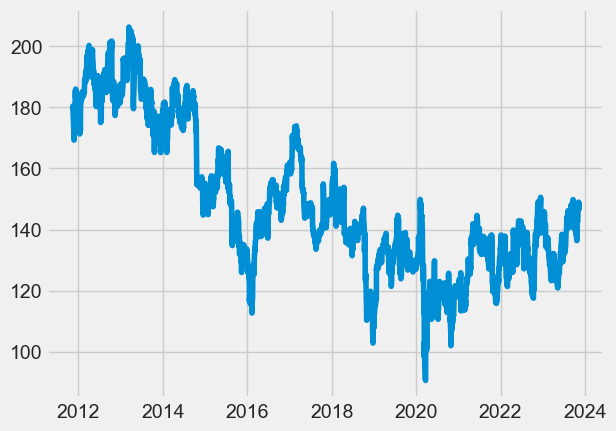

In [4]:
# Convert 'Date' column to pandas datetime format for easy plot
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [5]:
# Function to create snippets of data of some window size
def create_time_series_snippets(df, window_size):
    df = deepcopy(df)
    df.set_index('Date', inplace=True)
    for i in range(1, window_size+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    return df

In [7]:
window_size  = 7
snippet_data = create_time_series_snippets(data, window_size = window_size)
snippet_data.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2011-11-23,170.124283,173.336517,173.499039,177.093689,177.562134,178.412994,180.449326,179.110901
2011-11-25,169.273422,170.124283,173.336517,173.499039,177.093689,177.562134,178.412994,180.449326
2011-11-28,174.196945,169.273422,170.124283,173.336517,173.499039,177.093689,177.562134,178.412994
2011-11-29,172.982788,174.196945,169.273422,170.124283,173.336517,173.499039,177.093689,177.562134
2011-11-30,179.732315,172.982788,174.196945,169.273422,170.124283,173.336517,173.499039,177.093689


In [8]:
snippet_data_np = snippet_data.to_numpy()
snippet_data_np.shape

(3011, 8)

In [9]:

# Function to Normalize Function
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu


In [10]:
# Normalize Data
# normalize
scaler = Normalizer()
#scaled_data = scaler.fit_transform(data)
snippet_data_np = scaler.fit_transform(snippet_data_np)
snippet_data_np.shape

(3011, 8)

In [11]:
# create input (X) and label (y) pairs
# Note: First Column of our snippet data is label y
X = snippet_data_np[:, 1:]
y = snippet_data_np[:, 0]
print(f'The size of input is X is Number samples X Window_size:{X.shape}')
print(f'The size of output Y is {y.shape}')

The size of input is X is Number samples X Window_size:(3011, 7)
The size of output Y is (3011,)


In [12]:
# Reverse the X such that the first element in the sequence input is t - window_size
# i.e,we send the most recent close stock as first element. Refer to data.head() above
X = deepcopy(np.flip(X, axis=1))

In [13]:
# Use Part of X as training and part as validation/test
split_index = int(len(X) * 0.95)
split_index

# Train and Test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2860, 7), (151, 7), (2860,), (151,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_test = X_test.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2860, 7, 1), (151, 7, 1), (2860, 1), (151, 1))

In [15]:
# Convert to torch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2860, 7, 1]),
 torch.Size([151, 7, 1]),
 torch.Size([2860, 1]),
 torch.Size([151, 1]))

In [16]:
# Create Torch DataSet
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
# Torch Data Loader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Choose Device
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print('The device being used is:', device)


The device being used is: cpu


In [19]:
# batch example from the train_loader
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


### Build a LSTM model. 
1. We will add a fully connected layer at the end to create an 
output of desired size. 

In [20]:
# Define a LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize a0 and c0
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [21]:
#Instantiate a model
input_size = 1
hidden_size = 32
num_layers = 2
model = LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_loader)
    print('Epoch # :', epoch)
    print('Train Loss: {0:.4f}'.format(avg_train_loss))

In [24]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_test_loss = running_loss / len(test_loader)

    print('Val Loss: {0:.4f}'.format(avg_test_loss))
    print('***************************************************')

In [25]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch # : 0
Train Loss: 0.2050
Val Loss: 0.0130
***************************************************
Epoch # : 1
Train Loss: 0.0231
Val Loss: 0.0112
***************************************************
Epoch # : 2
Train Loss: 0.0201
Val Loss: 0.0101
***************************************************
Epoch # : 3
Train Loss: 0.0176
Val Loss: 0.0077
***************************************************
Epoch # : 4
Train Loss: 0.0154
Val Loss: 0.0063
***************************************************
Epoch # : 5
Train Loss: 0.0132
Val Loss: 0.0054
***************************************************
Epoch # : 6
Train Loss: 0.0116
Val Loss: 0.0053
***************************************************
Epoch # : 7
Train Loss: 0.0101
Val Loss: 0.0041
***************************************************
Epoch # : 8
Train Loss: 0.0096
Val Loss: 0.0036
***************************************************
Epoch # : 9
Train Loss: 0.0087
Val Loss: 0.0050
***************************************************


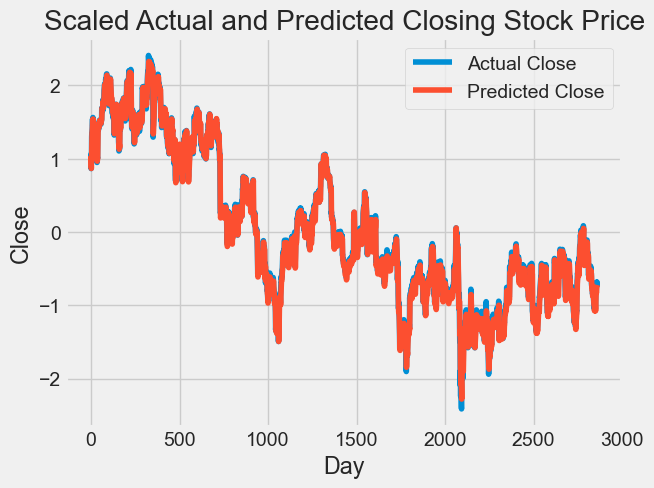

In [26]:
# Plot the actual training time series and predicted time series. 
# This part of the time series is already seen by network during the training
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.title("Scaled Actual and Predicted Closing Stock Price")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
# Scale back the predicted training closing data
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], window_size+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = deepcopy(dummies[:, 0])
#train_predictions

In [28]:
# Scale back the actual training closing data (labels)
dummies = np.zeros((X_train.shape[0], window_size+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = deepcopy(dummies[:, 0])
#new_y_train

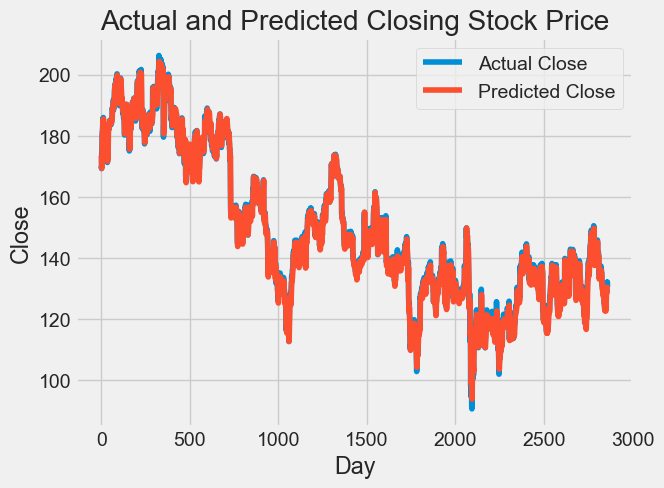

In [29]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.title("Actual and Predicted Closing Stock Price")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()



In [30]:
# Get Predictions for unseen data
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], window_size+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = deepcopy(dummies[:, 0])
#test_predictions

In [31]:
# Scale back the labels of unseen time-series
dummies = np.zeros((X_test.shape[0], window_size+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = deepcopy(dummies[:, 0])
#new_y_test

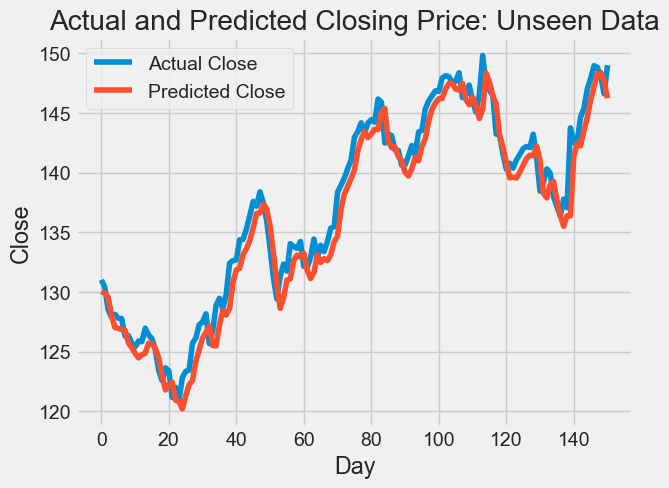

In [32]:
# Scale back the predictions of unseen time-series
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title('Actual and Predicted Closing Price: Unseen Data')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
